# deCIFer: XRD Simulation & Visualization  

- Generates continuous XRD patterns from CIF structures.
- Visualizes XRD intensity variations across different simulated noise and peak broadening

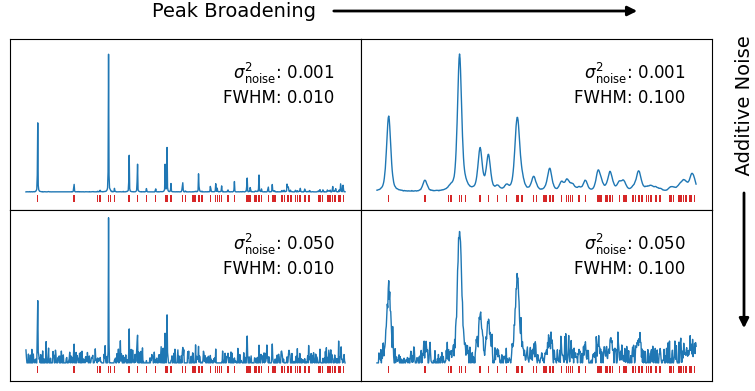

In [13]:
import gzip
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from decifer.utility import (
    generate_continuous_xrd_from_cif,
    discrete_to_continuous_xrd
)

# Set global font size
plt.rcParams.update({
    "font.size": 12,  # Global font size
    "axes.titlesize": 14,  # Axes title size
    "axes.labelsize": 14,  # Axes label size
    "xtick.labelsize": 10,  # X-axis tick labels
    "ytick.labelsize": 10,  # Y-axis tick labels
    "legend.fontsize": 12,  # Legend font size
})

def load(file_path, debug_max=None):
    """Load the data from a gzip-compressed pickle file."""
    with gzip.open(file_path, 'rb') as f:
        df = pd.DataFrame(pickle.load(f))

    xrd_q, xrd_iq, cifs, spacegroups = [], [], [], []
    for i, entry in df.iterrows():
        if debug_max is not None and i >= debug_max:
            break
        xrd_q.append(entry['xrd_q_discrete_sample'])
        xrd_iq.append(entry['xrd_iq_discrete_sample'])
        cifs.append(entry['cif_sample'])
        spacegroups.append(entry['spacegroup_sym_sample'])

    return xrd_q, xrd_iq, cifs, spacegroups

# File paths
file_path_deCIFer = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_(CompSG_N-0p00_B-0p05).pkl.gz"
file_path_UdeCIFer = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer-U_(CompSG).pkl.gz"

# Load data
xrd_qs, xrd_iqs, cifs, spacegroups = load(file_path_deCIFer, debug_max=1)

# Generate continuous XRD from CIF
xrd = generate_continuous_xrd_from_cif(
    cifs[0],
    noise_range=None,
    fwhm_range=(0.01, 0.01),
    mask_prob=None,
    intensity_scale_range=None,
    qmin=0.5,
    qmax=7.0,
    debug=True,
)

xrd_qs = xrd['q_disc']
xrd_iqs = xrd['iq_disc']

# Define grid parameters
num_noise = 2
num_broad = 2
fig, axes = plt.subplots(num_noise, num_broad, figsize=(8, 4), sharex=True, sharey=True)

# Generate plots for different noise and broadness values
for i, noise in enumerate(np.linspace(0.001, 0.05, num_noise)):
    for j, broad in enumerate(np.linspace(0.01, 0.10, num_broad)):
        xrd = discrete_to_continuous_xrd(
            batch_q=torch.from_numpy(xrd_qs).unsqueeze(0),
            batch_iq=torch.from_numpy(xrd_iqs).unsqueeze(0),
            noise_range=(noise, noise),
            fwhm_range=(broad, broad),
            mask_prob=None,
            intensity_scale_range=None,
            qmin=0.5,
            qmax=7.0,
        )

        axes[i, j].plot(xrd['q'], xrd['iq'].squeeze(0), lw=1.0)
        axes[i, j].grid(alpha=0.5)
        axes[i, j].set_yticks([])
        axes[i, j].set_xticks([])

        # if j == 0:
            # axes[i, j].set_ylabel("Norm. Intensity")
        # if i == num_noise - 1:
            # axes[i, j].set_xlabel("$Q\;[\mathrm{\AA}^{-1}]$")

        axes[i, j].bar(
            xrd_qs,
            height=-np.ones_like(xrd_iqs) * 0.05,
            width=0.025,
            bottom=-0.025,
            color='#d62728',
            label='Bragg Reflections',
        )

        axes[i, j].text(
            x=4.5,
            y=0.65,
            s=f'  $\\sigma_{{\\mathrm{{noise}}}}^2$: {noise:1.3f}\nFWHM: {broad:1.3f}',
        )

# Add arrows for indicating noise and broadness directions
arrow_properties = dict(facecolor='k', edgecolor='k', arrowstyle='-|>', lw=2)

# Broadness arrow and text (at the top, pointing right)
axes[0, -1].annotate(
    'Peak Broadening  ', 
    ha='center',
    va='center',
    xy=(0.8, 0.95), 
    xytext=(0.3, 0.95),
    arrowprops=arrow_properties,
    xycoords='figure fraction', 
    textcoords='figure fraction',
    fontsize=14,
)

axes[0, -1].annotate(
    '  Additive Noise', 
    ha='center',
    va='center',
    xy=(0.93, 0.15), 
    xytext=(0.93, 0.7),
    arrowprops=arrow_properties,
    xycoords='figure fraction', 
    textcoords='figure fraction',
    fontsize=14,
    rotation=90
)

fig.tight_layout()
fig.subplots_adjust(wspace=0.0, hspace=0.0, top=0.9, right=0.9)
plt.show()


# Optional: Save the figure
fig.savefig('noise_broadness.svg', transparent=True)#, bbox_inches='tight', pad_inches=0.1)